# Atmospheric CO2
 
```{glue:figure} trend_fig
:scale: 50%
:align: right
```

In this notebook we will download the data from the [Mauna Loa Station](https://gml.noaa.gov/obop/mlo/) and we will create a time series plot and a table summarizing the evolution of CO2 since {glue:text}`start_year:.0f`


## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import os

import os.path as op

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp

from myst_nb import glue 
from IPython.display import HTML

import sys
sys.path.append("../../../functions")
from data_downloaders import download_HOT_CO2_data, download_MLO_CO2_data

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting import plot_timeseries
from ind_setup.plotting_int import plot_timeseries_interactive, fig_int_to_glue
from ind_setup.tables import plot_df_table

## Observations from Mauna Loa

First we download our data from the Atmospheric C02 from the Mauna Loa Observatory ([ESRL at NOAA](https://www.esrl.noaa.gov/)) <br>
And we'll establish our directory for saving and reading data, and our output files.

The function download_MLO_CO2_data will be in charge of processing the data converting to the right units,  
 The next code block:
 - extracts CO2 data from 1958
 - process NaN values
 - generate an easy to use dataframe
 
 The resulting data is stored in the variable 'MLO_data' and saved in "path_data" as 'MLO_co2.pkl'

In [14]:
update_data = True
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [6]:
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt'

if update_data:
    MLO_data = download_MLO_CO2_data(url)
    MLO_data.to_pickle(op.join(path_data, 'MLO_co2.pkl'))
else:
    MLO_data = pd.read_pickle(op.join(path_data, 'MLO_co2.pkl'))    

## Analysis

At this piece of code we will create a new column with the deseasoned CO2 using an open window of 12 months for each data point

In [7]:
MLO_data['CO2_deseasoned'] = MLO_data['CO2'].rolling(window=12, center=True).mean()
glue("n_years", len(np.unique(MLO_data.index.year)), display=False)
glue("co2_2024", int(MLO_data.loc['2024'].CO2.mean()), display=False)
glue("start_year", MLO_data.dropna().index[0].year, display=False)

### Plot the timeseries
Here, we'll plot the CO2 time series. For that purpose we are creating a dictionary with all the lines that we want to plot in the same figure. <br>
In this specific case, we are going to plot the raw CO2 monthly data, as well as the deseasoned one. <br>
The figure will as well show the linear trend that results for fitting the data over time, showing wether the trend is or not statistically significant (p_value over or above .05) and the value of the trend

In [8]:
dict_plot = [{'data' : MLO_data, 'var' : 'CO2', 'ax' : 1, 'trendline' : True, 'label' : 'MLO: CO2'},
             {'data' : MLO_data, 'var' : 'CO2_deseasoned', 'ax' : 1, 'trendline' : False, 'label' : 'MLO: CO2 (Deseasoned)'}]

In [16]:
fig, trend = plot_timeseries_interactive(dict_plot, trendline=True, figsize=(20, 10), return_trend=True);
fig.write_html(op.join(path_figs, 'F1_CO2_trend.html'), include_plotlyjs="cdn")


glue("trend", float(trend[0]), display=False)
glue("change", float(trend[0]*len(np.unique(MLO_data.index.year))), display=False)
glue("trend_fig", fig_int_to_glue(fig), display=False)

**Fig.** Monthly Mean Concentration of Atmospheric CO2 at Mauna Loa since {glue:text}`start_year`. The blue line represents the monthly mean values, centered on the middle of each month. The red line represents the same, after correction for the average seasonal cycle.  The solid black line represents the trend, which is  statistically significant (p < 0.05).  The annual oscillations at Mauna Loa are due to the seasonal imbalance between the photosynthesis and respiration of plants on land. From NOAA ESRL Global Monitoring Division. https://www.esrl.noaa.gov/gmd/ccgg/trends/ 


### Generate table
The final step is to generate a table sumarizing different metrics of the data analyzed in the plots above

In [11]:
MLOy = MLO_data[['CO2']].groupby(MLO_data.index.year).mean()
MLOy.index = pd.to_datetime(MLOy.index, format = '%Y')

Annual Stats

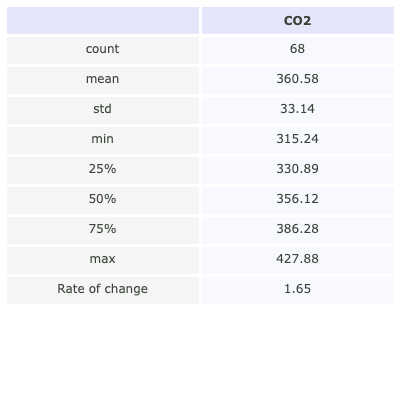

In [12]:
d = MLOy.describe()
d.loc['Rate of change'] = trend
fig = plot_df_table(np.round(d, 2), figsize = (400, 400))


Table. Annual Statistics of Atmospheric CO2 at Mauna Loa since 1958.